# Introduction

Imaging is a direct method for observing nature, primarily based on spatial and geometrical relationships. It typically involves some kind of wave probing a medium, and the recording of the spatial distribution of that wave after that interaction. The most common day-to-day method of imaging is the use of a human eye to observe nature. When the same process is performed instead by a machine, this is known as photography. This imaging *modality* uses optical light, often coming from the sun, and its reflection from surfaces, as captured by a camera.

For a scientist or engineer, it is important to understand that this image contains data. As with all data, the scope, nature and interpretation of that data is dependent on the observer. In this Chapter, we will begin with a brief discourse on how an image is defined, what it is made of, and some basic operations of dealing with colour and greyscale images. We will then go into two specific use cases for granular materials. One involves finding individual particles inside an image and tracking them over time, and is commonly referred to as Particle Tracking Velocimetry (PTV). The second technique, Digital Image Correlation (DIC, also known as Particle Image Velocimetry, or PIV), compares two similar images and tries to estimate the relative displacement between them by texture matching.

# What is an image?

An image is typically a regular 2D array with scalar or vectorial data stored at each point on the array. Each point is referred to as a *pixel*. If the data at each pixel is scalar, then the image is said to be *greyscale*, and the value at each point would be the *greylevel*. A value of zero would correspond to no greyness, and would therefore be black. The maximum possible value would correspond to completely white. (Note that in tomography (discussed elsewhere) this convention is actually inverted for historical reasons).

For a variety of reasons (primarily historical context, data storage and interopability requirements), images are typically stored as *unsigned integers*, rather than floating point values. The *unsigned* part means that there is no sign to the value, and it therefore must be greater than or equal to zero. The fact that it is an *unsigned integer* therefore means that there are a discrete number of values between zero and some maximum greylevel. An 8-bit image would use 8 bits of data storage, each of which could be a 0 or a 1, and would therefore have $2^8=256$ possible greylevel values, with zero corresponding to black and 255 corresponding to white. This *bit depth* is very common in optical imaging. With increasing bit depth, say for a 16-bit image (common in radiography), there are more discrete values available between zero and the maximum (here $2^{16}=65,536$), and finer changes in greylevel can be stored at the cost of increased file size and computational time.

## Getting started with Python

For the code examples below, we will use the programming language Python, which is the most common language for this type of analysis. Many open source packages are available to perform imaging using this language. To follow the worked examples below you will need the following packages installed: `numpy`, `matplotlib` and `imageio`. If you are running this code on Google Colab they're already installed. If you're running it on your own computer, you can install them at the command line with:

```
pip install numpy matplotlib imageio
```

Once installed, you can load these packages as

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

Let's investigate an image we prepared earlier. It is called `rainbow.jpg` and it is a photograph of a rainbow cake. We can load the image in Python using the command `plt.imread()`, which is part of the `matplotlib` package.

--2022-09-27 21:29:36--  http://www.benjymarks.com/alert/rainbow.jpg
Resolving www.benjymarks.com (www.benjymarks.com)... 65.254.227.224
Connecting to www.benjymarks.com (www.benjymarks.com)|65.254.227.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72952 (71K) [image/jpeg]
Saving to: ‘rainbow.jpg.1’

rainbow.jpg.1       100%[===================>]  71.24K  --.-KB/s    in 0.06s   

2022-09-27 21:29:36 (1.08 MB/s) - ‘rainbow.jpg.1’ saved [72952/72952]



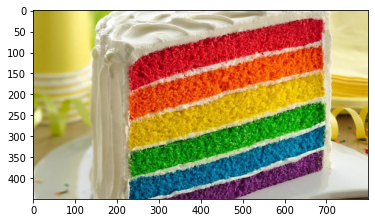

In [ ]:
!wget http://www.benjymarks.com/alert/rainbow.jpg # This downloads the image we are going to use

im = plt.imread('rainbow.jpg') # Load an image of a rainbow cake that we prepared earlier
plt.imshow(im) # show us the image
plt.show() # tell matplotlib to display the image

A typical camera records three values at each pixel, one each for the redness, greenness and blueness. We refer to this type of image as red-green-blue (RGB). These values are each recorded by separate sensors, that are sensitive to a range of wavelengths centred around red, green and blue, that are chosen to mimic the behaviour of the (non-colour blind) human eye. Cameras that record more than three values at each pixel are referred to as *multispectral* and are used in a variety of scientific and engineering applications. Cameras that record only a single value at each pixel are referred to as *monochrome* or *black and white*.

If we look a bit closer at the image of the cake, we can investigate what exactly this image is made up of. As stated above, the image is in fact an array of values. We can see what is going on by inspecting the `shape` of the array `im`.

In [ ]:
im.shape

(450, 800, 3)

The image is made up of individual pixels. There are 450 rows, 800 columns, and every pixel contains three values, one each for the intensity of red, green and blue. Let's separate the colours into individual two dimensional arrays, each 450 x 800 pixels.

In [ ]:
# get all of the red pixel values
red   = im[:,:,0]
# get all of the green pixel values
green = im[:,:,1]
# get all of the blue pixel values
blue  = im[:,:,2]

print(blue.shape)

(450, 800)


Now we can have a look at each of the colours separately.

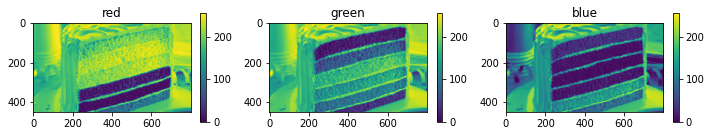

In [ ]:
# make a new figure, 12 inches wide and 2 inches tall
plt.figure(figsize=[12,2])

# make a plot in the left third of the figure
plt.subplot(131)
# make a title so we don't forget what this subplot is showing us
plt.title('red')
# show us just the red data
plt.imshow(red)
# add a colorbar
plt.colorbar() 

# now one in the middle third of the figure
plt.subplot(132)
plt.title('green')
plt.imshow(green) 
plt.colorbar()

# now the right third of the figure
plt.subplot(133) 
plt.title('blue')
plt.imshow(blue)
plt.colorbar()

plt.show()

Next to each plot is a *colour bar*. The values in the array have been rendered as a colour that is pulled from a *colour map*. The name of this map is *viridis* and it is the default choice when using `matplotlib`. This particular colour map is *sequential*, in that the colours change systematically from the minimum value to the maximum value. There are other types of colour scales available, such as *diverging* or *qualitative* scales. It is important to note that just because these images are drawn with a set of colours, it does not imply that the underlying data is vectorial. (i.e. `RGB`). The ambiguity here necessitates that a colour bar is shown next to all images that are not greyscale. Additionally, not all colour scales are made equal, and [significant research](https://bids.github.io/colormap/) has gone into creating and promoting those that represent data without bias (referred to as *perceptually uniform*), can be printed without significant data loss in greyscale, and are friendly to those with colour blindness. 

The values of each of the red, green and blue *channels* above lies somewhere in the range [0-255], and are most likely therefore 8-bit integers. We can check the data type in python via

In [ ]:
print(im.dtype)

uint8


This tells us that the *data type* is an *unsigned 8 bit integer*, as expected. Now lets try to isolate just the green slice of the cake. One way to do that is by picking a *threshold* value of green, and converting our the green subset of the image into a *binary* (or *boolean*) image. This kind of image can only have one of two values at each pixel: `True` or `False`.

In [ ]:
just_green = green > 140

print(just_green.dtype)

bool


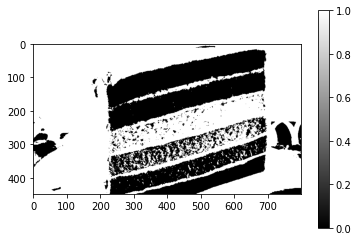

In [ ]:
plt.imshow(just_green, cmap='gray') # show the green channel, and use the 'gray' colormap so that it is rendered in greyscale
plt.colorbar()
plt.show()

This has done a reasonable job of isolating the single slice, but it has also selected all of the white areas, since whiter colours contains lots of red, green and blue at the same time. In fact, the slice it has selected isn't even the green slice, it is the yellow one. Even though the green slice is 'greener' than the yellow slice, the yellow slice is brighter, and therefore has more green in it.

## Colour spaces

Whilst an RGB colour image may make sense to be displayed on a computer screen (which these days is typically composed of a large number of tiny lights that glow, unsurprisingly, red, green and blue), it is actually quite inconvenient to find items according to their colour. For this reason, we often change our *colour space* from RGB to another, more convenient space. One such space is the hue-saturation-value (HSV) space.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/05/RGB_Cube_Show_lowgamma_cutout_a.png" alt="drawing" width="300"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/394px-HSV_color_solid_cylinder_saturation_gray.png" alt="drawing" width="300"/>

RGB and HSV colour spaces. (wikimedia)

In [ ]:
from matplotlib.colors import rgb_to_hsv # get the function we need from matplotlib

im_hsv = rgb_to_hsv(im) # Convert to hsv

print(im_hsv.shape)

(450, 800, 3)


We still have an array of the same size, but now instead of being in RGB space, it is in HSV. We can decompose this into three separate arrays with

In [ ]:
hue        = im_hsv[:,:,0]
saturation = im_hsv[:,:,1]
value      = im_hsv[:,:,2]

print(hue.shape)

(450, 800)


Let's have a look at what each of these arrays looks like

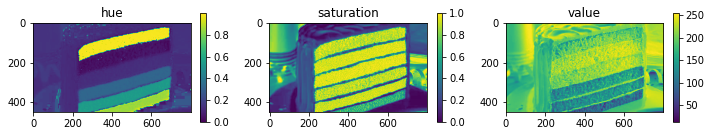

In [ ]:
plt.figure(figsize=[12,2])

plt.subplot(131)
plt.title('hue')
plt.imshow(hue)
plt.colorbar()

plt.subplot(132)
plt.title('saturation')
plt.imshow(saturation) 
plt.colorbar()

plt.subplot(133)
plt.title('value')
plt.imshow(value)
plt.colorbar()

plt.show()

In the *hue* image, we can see that each slice of the cake contains a reasonably uniform hue. Each of those slices has a reasonably high *saturation*, because there is a lot of colour there. The *value* image shows us a map of the brightness of the image everywhere. We can look at how frequent each of the values are in these channels with a *histogram*, to get a better idea of exactly what colours we have in the image.

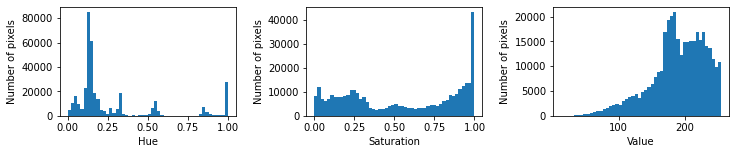

In [ ]:
plt.figure(figsize=[12,2])

plt.subplot(131)
# we need to flatten the hue array first so that we just get one histogram over the whole image
plt.hist(hue.flatten(),bins=50)
plt.xlabel('Hue')
plt.ylabel('Number of pixels')

plt.subplot(132)
plt.hist(saturation.flatten(),bins=50)
plt.xlabel('Saturation')
plt.ylabel('Number of pixels')

plt.subplot(133)
plt.hist(value.flatten(),bins=50)
plt.xlabel('Value')
plt.ylabel('Number of pixels')

# make a bit more space between the subplots so that we can see the labels
plt.subplots_adjust(wspace=0.4)
plt.show()

There is a small peak in the hue around 0.3. This must correspond to our green slice. Let's try to extract just these values into a binary image. 

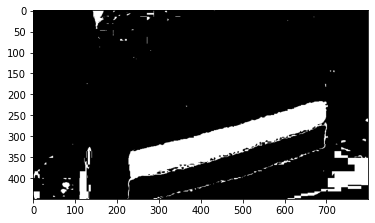

In [ ]:
just_green = (im_hsv[:,:,0] > 0.2) & (im_hsv[:,:,0] < 0.4)
plt.imshow(just_green, cmap='gray')
plt.show()

Now we're making progress! We have mostly isolated the green slice, but we still have lots of areas of slightly off-coloured white, which we could remove by also including a threshold for our *saturation* value.

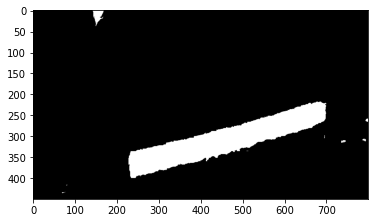

In [ ]:
just_green = (im_hsv[:,:,0] > 0.2) & (im_hsv[:,:,0] < 0.4) & (im_hsv[:,:,1] > 0.3)
plt.imshow(just_green, cmap='gray')
plt.show()

We are now left with our green slice, and some small parts of the background that are in fact quite a bit green. We will have to do something else to remove those parts.

# Morphological operations
There are a family of *morphological operators* which can be applied to binary (or with some extension greyscale) images to remove small areas of data, fill in holes, or other simple tasks. Each of these methods relies on an object referred to as a *structuring element*, or *kernel*. A structuring element is no more than yet another binary image. For example, below is the structuring element that represents a disk of radius 3 pixels.

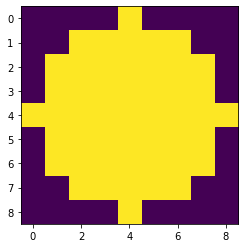

In [ ]:
structuring_element = np.array([[0,0,0,0,1,0,0,0,0],
                                [0,0,1,1,1,1,1,0,0],
                                [0,1,1,1,1,1,1,1,0],
                                [0,1,1,1,1,1,1,1,0],
                                [1,1,1,1,1,1,1,1,1],
                                [0,1,1,1,1,1,1,1,0],
                                [0,1,1,1,1,1,1,1,0],
                                [0,0,1,1,1,1,1,0,0],
                                [0,0,0,0,1,0,0,0,0]], dtype=bool)

plt.imshow(structuring_element)

A morphological operation occurs by going past every individual pixel in our image, and placing our structuring element over that pixel, and looking at all of the neighbouring pixels that lie under a `True` value in the structing element. In a morphological *dilation*, the value of the pixel of interest is set to `True` if **any** of the pixels within the structuring element are also `True`. For a morphological *erosion*, the opposite is the case, and the value of the pixel will be set to `False` if any of the pixels within the structuring element are `False`. In this way a dilation will cause areas of `True` pixels to expand (or dilate), and an erosion will cause areas of `Falses` to grow, shrinking (or eroding) the `True` values.

Let us see how this works on our cake slice.

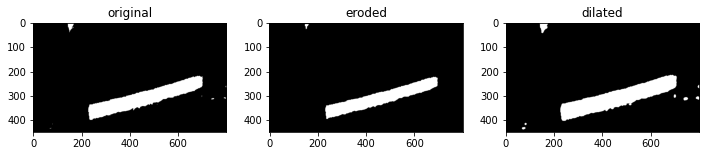

In [ ]:
from scipy.ndimage import binary_erosion, binary_dilation
eroded =  binary_erosion(just_green, structuring_element)
dilated = binary_dilation(just_green, structuring_element)

plt.figure(figsize=[12,2])

plt.subplot(131)
plt.title('original')
plt.imshow(just_green, cmap='gray')

plt.subplot(132)
plt.title('eroded')
plt.imshow(eroded, cmap='gray') 

plt.subplot(133)
plt.title('dilated')
plt.imshow(dilated, cmap='gray')

plt.show()

In the dilated image on the right above, we have managed to grow some of the spurious spots outside of the slice. In the eroded image in the middle, these spots are now gone, but we have also managed to erode away some of the inside of the slice where some small holes existed.

If we now apply the opposite processes, (e.g. first an erosion, and then a dilation), we can try to undo the damage we have caused and get back to almost where we started. These operations are referred to as *opening* and *closing*.

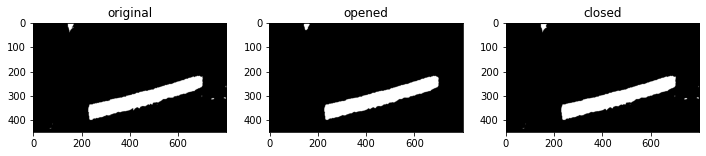

In [ ]:
opened =  binary_dilation(eroded, structuring_element)
closed = binary_erosion(dilated, structuring_element)

plt.figure(figsize=[12,2])

plt.subplot(131)
plt.title('original')
plt.imshow(just_green, cmap='gray')

plt.subplot(132)
plt.title('opened')
plt.imshow(opened, cmap='gray') 

plt.subplot(133)
plt.title('closed')
plt.imshow(closed, cmap='gray')

plt.show()

Our closed image looks remarkably similar to our original image. Most of the existing speckle remains, as it is larger than the structuring element. Our opened image, however, is looking rather improved. The smaller speckle has disappeared and the cake slice is back to almost its original shape. Our only remaining issue is the large area at the top of the image, but we can deal with that. The next step is to find the connected region that defines this cake slice, and measure its properties.

# Image segmentation

We have now a binary image that closely represents what we want to find. There are large *connected* regions of `True` values, and we would like to *segment* the image and give different *labels* to each of these connected regions. The largest region, hopefully, will be our cake slice.

Found 2 features


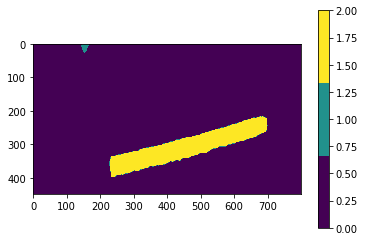

In [ ]:
from scipy.ndimage import label

labelled_image, num_features = label(opened)

print(f'Found {num_features} features')

# lets make our own colour map so that we can visualise this properly
from matplotlib import cm
# one colour for each feature and the background
viridis_qualitative = cm.get_cmap('viridis', num_features+1)

plt.imshow(labelled_image,cmap=viridis_qualitative)
plt.colorbar()
plt.show()

You can see that we have found more than one *feature* in our image (we found two!), and that each connected region of pixels, or feature, has been labelled with an integer value corresponding to its feature number, with the background having a value of zero. The last step is to calculate some properties of each of these labelled regions, which can be achieved by

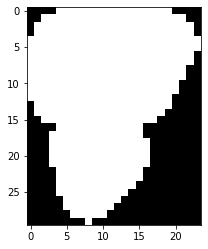

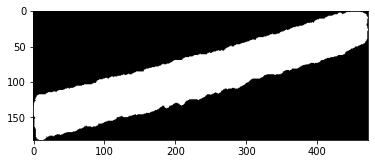

In [ ]:
from scipy.ndimage import find_objects

# this is a list of 'slices', or references to where in the array the original data is stored
objects = find_objects(labelled_image)

for i in range(len(objects)):
    plt.imshow(labelled_image[objects[i]], cmap='gray')
    plt.show()

We can find out the area and location of about our objects quite easily.

Area of object 1 is 480 pixels
Area of object 2 is 55092 pixels


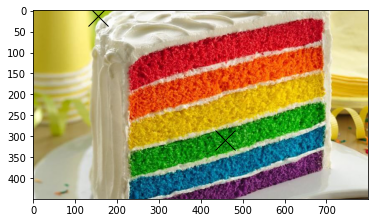

In [ ]:
from scipy.ndimage import center_of_mass

# Lets draw some black crosses over the location of the regions we found
plt.imshow(im)
for i in range(len(objects)):
    # the 0th label is the background, need to skip it
    c = center_of_mass(opened, labelled_image, [i+1])[0]
    # the area is just the number of pixels in the binary image
    print(f'Area of object {i+1} is {(labelled_image[objects[i]]).sum()} pixels')
    # annoyingly scipy flips the order of the horizontal and vertical locations
    plt.plot(c[1],c[0],'kx',markersize=20)

The last remaining step in this instance is just to store only the largest object, but since we have already calculated their areas, this should be relatively straightforward.

# Particle Tracking Velocimetry

## Technical digression: loading a video
You will probably at some stage need to load a video with Python. One of the ways to do this is by using the `imageio.get_reader` function. When instantiating this object you are telling Python that you will use a certain video file as a variable. When calling `get_reader()` you still haven't read the frames from the video. 
See what you can find out about your video file by using the `video.get_meta_data()` method.

```video = imageio.get_reader('filename.mp4', 'ffmpeg') # change the filename to whatever your file is called```

After loading the video, you can now start reading the frames of the video that you will modify. Each frame in the video will be available as a single image.

```
for image in video.iter_data():
    print(image.shape)
```

## Exercise 1
Shoot a video of ball flying/bouncing/rolling with your phone or laptop. Then:
  1. Load each frame in a loop and do the same procedure as above for each frame.
  2. Save the coordinates of the ball's center into an array.
  3. Calculate the horizontal and vertical components of ball's velocity.
  4. Plot the trajectory of the ball on top of the first image of the video.
  5. Calculate the initial force applied to the ball and the drag coefficient

# Digital Image Correlation (for beginners)

Depending on the resolution of your image, it may not be possible (or even preferable) to track individual particles in each image. An alternative method, that is used widely across many branches of physics, biology and engineering is *Digital Image Correlation*. This same methodology is also termed *Particle Image Velocimetry*. This technique involves comparing *patches* of each image between frames in a time series, and attempting to find the best possible match, so that we can identify where the material has moved between frames.

Necessarily then we must do the following:
 1. Record a time series of images
 2. Load each image sequentially
 3. Split each image into a set of patches
 4. For each patch, identify where in the subsequent image we can find that patch

There are many variations of this technique, with varying level of refinement, accuracy, robustness and reliability. Here, we will detail the simplest, least robust and computationally least efficient method. In a later lecture, further information will be provided on how to do this process better.

Here, we will consider the two following images. As is conventional, we will consider the original, undeformed image to be `F`, and the deformed image, where we are trying to find our patches, to be `G`:

--2022-09-27 21:35:56--  http://www.benjymarks.com/alert/before.png
Resolving www.benjymarks.com (www.benjymarks.com)... 65.254.227.224
Connecting to www.benjymarks.com (www.benjymarks.com)|65.254.227.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2626460 (2.5M) [image/png]
Saving to: ‘before.png’

before.png          100%[===================>]   2.50M  10.5MB/s    in 0.2s    

2022-09-27 21:35:57 (10.5 MB/s) - ‘before.png’ saved [2626460/2626460]

--2022-09-27 21:35:57--  http://www.benjymarks.com/alert/after.png
Resolving www.benjymarks.com (www.benjymarks.com)... 65.254.227.224
Connecting to www.benjymarks.com (www.benjymarks.com)|65.254.227.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627113 (2.5M) [image/png]
Saving to: ‘after.png’

after.png           100%[===================>]   2.50M  10.6MB/s    in 0.2s    

2022-09-27 21:35:57 (10.6 MB/s) - ‘after.png’ saved [2627113/2627113]



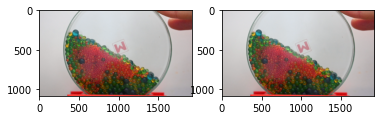

In [ ]:
!wget http://www.benjymarks.com/alert/before.png # This downloads the image we are going to use
!wget http://www.benjymarks.com/alert/after.png # This downloads the image we are going to use

F = plt.imread('before.png')
G = plt.imread('after.png')

plt.subplot(121)
plt.imshow(F)
plt.subplot(122)
plt.imshow(G)
plt.show()

To process these images, we will need to convert the vectorial `RGB` images to greyscale. One potential way could be to take the image brightness by converting to `HSV` and then taking the `value` channel only.

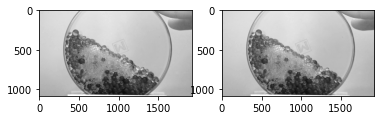

In [ ]:
# the third channel is the value
F_gray = rgb_to_hsv(F)[:,:,2]
G_gray = rgb_to_hsv(G)[:,:,2]

plt.subplot(121)
# use a grayscale colormap so that it looks gray
plt.imshow(F_gray, cmap='gray')
plt.subplot(122)
plt.imshow(G_gray, cmap='gray')
plt.show()

We could tidy up these images by looking for saturated areas, or even more simply by cropping to a region of interest

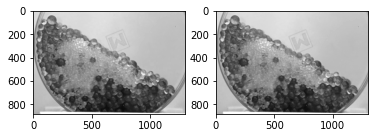

In [ ]:
# select from 200 pixels from the top, all the way to the bottom, and from 300 pixels from the left to 1600 pixels across
F_gray_cropped = F_gray[200:,300:1600]
G_gray_cropped = G_gray[200:,300:1600]

plt.subplot(121)
plt.imshow(F_gray_cropped, cmap='gray')
plt.subplot(122)
plt.imshow(G_gray_cropped, cmap='gray')
plt.show()

## Patches

Now that we have two nice images ready to process, the next step is to split our image into patches. This necessitates defining

 1. What size patches we want
 2. Where those patches should be in the image
 
The choice of patch size should be determined by considering the size of the features of interest in the image. We wish to track these patches between frames, so the patch should be large enough so that features should be persistent between frames. There are in general no formal requirements for the patch size, except that the result of your measurement should be insensitive to small changes in the patch size itself. This could be checked by running your analysis for a variety of patch sizes and examining the result.

For simplicity, patches are typically generated over a grid. The patches themselves, however, can *overlap*, so that the grid spacing is not necessarily the same as the patch size. The more patches used, the finer the resolution of the final data that is produced.

## Pixel Searching

Let us pull out a 128 x 128 pixel patch from somewhere inside both images

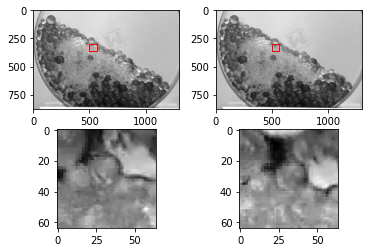

In [ ]:
from matplotlib.patches import Rectangle

patch_width = 64
top = 300
left = 500

F_patch = F_gray_cropped[top:top+patch_width,left:left+patch_width]
G_patch = G_gray_cropped[top:top+patch_width,left:left+patch_width]

ax = plt.subplot(221)
# show the source image
plt.imshow(F_gray_cropped, cmap='gray')
# draw a rectangle to show where our patch came from
ax.add_patch(Rectangle([left,top],
                       patch_width,
                       patch_width,
                       edgecolor='red',
                       facecolor='None'
                      )) 
ax = plt.subplot(222)
plt.imshow(G_gray_cropped, cmap='gray')
ax.add_patch(Rectangle([left,top],
                       patch_width,
                       patch_width,
                       edgecolor='red',
                       facecolor='None'
                      ))
plt.subplot(223)
plt.imshow(F_patch,cmap='gray')
plt.subplot(224)
plt.imshow(G_patch,cmap='gray')
plt.show()

We can see if there is any change between the images directly by calculating the difference of the two images

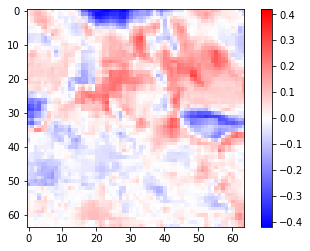

In [ ]:
err = F_patch-G_patch

plt.imshow(err,
           # set the limits of the colorbar so that the image is symmetrical about zero
           vmin=-np.max(np.abs(err)),
           vmax= np.max(np.abs(err)),
           # render it so that blue is negative and red is positive. This is a diverging colour map.
           cmap='bwr')
plt.colorbar()
plt.show()

We can see directly that near the free surface (top right of the image) it is changing a lot, and lower down it is changing less. One way to measure the entire difference between the images would be to calculate the *sum of squared differences* as

$$ \eta = \sum_x \big((F(x) - G(x)\big)^2 $$

where $x$ are all of the pixels in the two cropped images. This can be done as

In [ ]:
eta = np.sum(np.square(F_patch - G_patch))
print(eta)

38.400955


So there is a measurable difference between these patches. Presumably, that is because the particles have moved between images. Lets see if we can find them by looking not just at this current patch in `G`, but also in nearby patches 

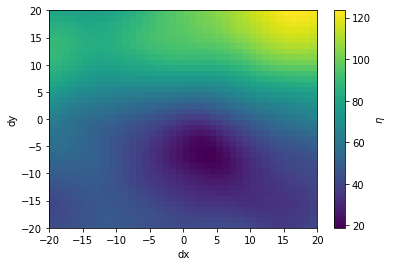

In [ ]:
# width of the patch
patch_width = 64
# coordinate of the top of the patch
top = 300
# coordinate of the left of the patch
left = 500
# search this many pixels left/right/up/down from the centre
max_search_range = 20

# just use one reference patch
F_patch = F_gray_cropped[top:top+patch_width,left:left+patch_width]
# an array to store all of our eta values in
eta = np.zeros([2*max_search_range+1,2*max_search_range+1])
# counter for which dx we are up to
i = 0
# counter for which dy we are up to
j = 0

# list of pixels we want to search over
search_horizontal = np.arange(-max_search_range,max_search_range+1)
search_vertical   = np.arange(-max_search_range,max_search_range+1)

for dx in search_horizontal:  
    # reset i for each row
    i = 0
    for dy in search_vertical:
        # move the patch up/down by a distance dy, note that positive is down
        this_top = top - dy
        # move the patch left/right by a distance dx
        this_left = left + dx
        # get this patch
        G_patch = G_gray_cropped[this_top:this_top+patch_width,this_left:this_left+patch_width]
        # calculate the sum of squared differences
        eta[i,j] = np.sum(np.square(F_patch - G_patch))
        # increment i by 1
        i += 1
    # increment j by 1
    j += 1

plt.pcolormesh(search_horizontal,search_vertical,eta,shading='auto')
plt.xlabel('dx')
plt.ylabel('dy')
plt.colorbar(label='$\eta$')
plt.show()

As we can see, the total error varies when we move the patch around. The minimum error will give us the best match between the two patches, and we therefore can identify that the material has moved to the right and down. We can calculate the displacement as

3 -6


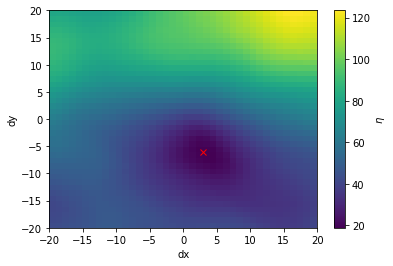

In [ ]:
# get the indices of the minima from eta
j,i = np.unravel_index(eta.argmin(), eta.shape)
# find the corresponding dx and dy
displacement_x = search_horizontal[i]
displacement_y = search_vertical[j]
print(displacement_x, displacement_y)

plt.pcolormesh(search_horizontal,search_vertical,eta,shading='auto')
plt.plot(displacement_x,displacement_y,'rx')
plt.xlabel('dx')
plt.ylabel('dy')
plt.colorbar(label='$\eta$')
plt.show()

After applying this technique to a large number of patches, it is possible to recover the following velocity field.

<img src="http://www.benjymarks.com/alert/quiver.png" width=300></img>

Velocity field as calculated by Digital Image Correlation.

This patch of material appears to be flow down and to the right, and moved approximately 3 pixels to the right while moving 6 pixels downwards. We can repeat this process for many different patches to create a full field of measurements of the displacement.

## What to do with all of this data?

In many geotechnical applications, we typically want to relate the strain with the stress. We don't have much of an idea (yet!) about the stress field, but we can calculate the strain field quite easily since the velocity field is calculated on a regular grid. If we have two 2-dimensional arrays `u` and `v` that represent the horizontal and vertical velocity, with grid spacings `dx` and `dy`, we can calculate the volumetric and shear strain rates as

```
du_dx, du_dy = np.gradient(u,dx,dy)
dv_dx, dv_dy = np.gradient(v,dx,dy)

volumetric_strain_rate = (du_dx + dv_dy)/2.
shear_strain_rate = (du_dy + dv_dx)/2.
```

## Software options
There are many free, open source alternatives for performing digital image correlation. A non-exhaustive list of common options as of 2022 are:

- MATLAB based:
  - [PIVLab](https://pivlab.blogspot.com/)
  - [GeoPIV-RG](https://www.geopivrg.com/)
- Python based:
  - [OpenPIV](http://www.openpiv.net/)
  - [spam](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/intro.html)
- Smartphone based:
  - [SmartPIV for Android](https://play.google.com/store/apps/details?id=de.tu_ilmenau.secsy.smartpiv&hl=en&gl=US)
  - [SmartPIV for iPhone](https://apps.apple.com/us/app/smartpiv/id1471308387)

## Exercise 2
1. Measure the displacement *field* of the two imagaes by applying the above method to a set of patches arranged on a regular grid. 
2. Use this data to calculate the volumetric strain rate field.